<div style='background-image: url("https://tinyurl.com/587zdbkm/title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Finite Element Method - Elastic Wave Equation 1D</div>
        </div>
    </div>
</div>

**This notebook covers the following aspects:**
* Initialize and setup of the finite element solution for the 1D wave equation
* Define the Mass Matrix and Stiffness Matrix and visually inspect their structure
* Implementation of a finite difference scheme for comparision with the finite element scheme
* The finite element solution using the computed mass matrix M and stiffness matrix K 

#### Exercise:

* Change the frequency content of the source time function,  compare accuracy
* Change "eps" (CFL limit) in Cell 2, which method explodes first?
* Appreciate the similarity of FD and FE algorithms in this matrix formulation!


## Basic Equations
This notebook presents a finite element code for the 1D elastic wave equation. Additionally, a solution using finite difference scheme is given for comparison.

The problem of solving the wave equation

\begin{equation}
\rho(x) \partial_t^2 u(x,t) = \partial_x (\mu(x) \partial_x u(x,t)) + f(x,t)
\end{equation}

using the finite element method is done after a series of steps performed on the above equation.

1) We first obtain a weak form of the wave equation by integrating over the entire physical domain $D$ and at the same time multiplying by some basis $\varphi_{i}$. 

2) Integration by parts and implementation of the stress-free boundary condition is performed.

3) We approximate our unknown displacement field $u(x, t)$ by a sum over space-dependent basis functions $\varphi_i$ weighted by time-dependent coefficients $u_i(t)$.

\begin{equation}
u(x,t) \ \approx \ \overline{u}(x,t) \ = \ \sum_{i=1}^{n} u_i(t) \ \varphi_i(x)
\end{equation}

4) Utilize the same basis functions used to expand $u(x, t)$ as test functions in the weak form, this is the Galerkin principle.

5) We can turn the continuous weak form into a system of linear equations by considering the approximated displacement field.

\begin{equation}
\mathbf{M}^T\partial_t^2 \mathbf{u} + \mathbf{K}^T\mathbf{u} = \mathbf{f}
\end{equation}

6) For the second time-derivative, we use a standard finite-difference approximation. Finally, we arrive at the explicit time extrapolation scheme.

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

where $\mathbf{M}$ is known as the mass matrix, and $\mathbf{K}$ the stiffness matrix.

7) As interpolating functions, we choose interpolants such that $\varphi_{i}(x_{i}) = 1$ and zero elsewhere. Then, we transform the space coordinate into a local system. According to $\xi = x − x_{i}$ and $h_{i} = x_{i+1} − x_{i}$, we have:

<p style="width:35%;float:right;padding-left:50px">
<img src=fig_fe_basis_h.png>
<span style="font-size:smaller">
</span>
</p>

\begin{equation}
 \varphi_{i}(\xi) =
  \begin{cases}
    \frac{\xi}{h_{i-1}} + 1  & \quad \text{if} \quad -h_{i-1} \le \xi \le 0\\
    1 + \frac{\xi}{h_{i}}    & \quad \text{if} \quad 0 \le \xi \le h_{i}\\
    0  & \quad elsewhere\\
  \end{cases}
\end{equation}

with the corresponding derivatives

\begin{equation}
 \partial_{\xi}\varphi_{i}(\xi) =
  \begin{cases}
    \frac{1}{h_{i-1}}  & \quad \text{if} \quad -h_{i-1} \le \xi \le 0\\
   -\frac{1}{h_{i}}    & \quad \text{if} \quad 0 \le \xi \le h_{i}\\
    0  & \quad elsewhere\\
  \end{cases}
\end{equation}

The figure on the left-hand side illustrates the shape of $\varphi_{i}(\xi)$ and $\partial_{\xi}\varphi_{i}(\xi)$ with varying $h$.

Code implementation starts with the initialization of a particular setup of our problem. Then, we define the source that introduces perturbations following by initialization of the mass and stiffness matrices. Finally, time extrapolation is done.

In [11]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
%matplotlib ipympl

import matplotlib.pyplot as plt
import matplotlib.animation as animation


### 1. Initialization of setup

In [12]:
# Initialization of setup
# ---------------------------------------------------------------
# Basic parameters
nx    = 200    # Number of collocation points  
xmax  = 10000.  # Physical dimension [m]
vs    = 3000    # Wave velocity [m/s] 
ro0   = 2500    # Density [kg/m^3]
nt    = 2000    # Number of time steps
isx   = 500     # Source location [m] 
eps   = 0.5     # Stability limit
iplot = 20      # Snapshot frequency

dx = xmax/(nx-1)           # calculate space increment
x  = np.arange(0, nx)*dx   # initialize space coordinates
x  = np.transpose(x)

h = np.diff(x)  # Element sizes [m]

# parameters
ro = x*0 + ro0
mu = x*0 + ro*vs**2

# time step from stabiity criterion
dt = eps*dx/np.max(np.sqrt(mu/ro))
# initialize time axis
t   = np.arange(1, nt+1)*dt  

# ---------------------------------------------------------------
# Initialize fields
# ---------------------------------------------------------------
u    = np.zeros(nx)
uold = np.zeros(nx)
unew = np.zeros(nx)

p    = np.zeros(nx)
pold = np.zeros(nx)
pnew = np.zeros(nx)

### 2. Source time function

In 1D the propagating signal is an integral of the source time function. As we look for a Gaussian waveform, we initialize the source time function $f(t)$ using the first derivative of a Gaussian function.

\begin{equation}
f(t) = -\dfrac{2}{\sigma^2}(t - t_0)e^{-\dfrac{(t - t_0)^2}{\sigma^2}}
\end{equation}

Initialize a source time function called 'src'.  Use $\sigma = 20 dt$ as Gaussian width, and time shift $t_0 = 3\sigma$. Then, visualize the source in a given plot.

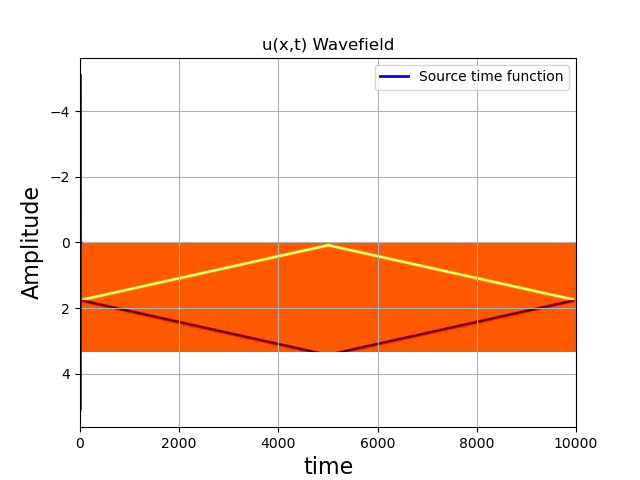

In [13]:
# Initialization of the source time function
# ---------------------------------------------------------------
pt  = 20*dt     # Gaussian width
t0  = 3*pt      # Time shift
src = -2/pt**2 * (t-t0) * np.exp(-1/pt**2 * (t-t0)**2)

# Source vector
# ---------------------------------------------------------------
f = np.zeros(nx); f[isx:isx+1] = f[isx:isx+1] + 1.

# ---------------------------------------------------------------
# Plot source time fuction
# ---------------------------------------------------------------
plt.plot(t, src, color='b', lw=2, label='Source time function')
plt.ylabel('Amplitude', size=16)
plt.xlabel('time', size=16)
plt.legend()
plt.grid(True)
plt.show()

### 3. The Mass Matrix
Having implemented the desired source, now we initialize the mass and stiffness matrices. In general, the mass matrix is given by

\begin{equation}
M_{ij} = \int_{D} \rho \varphi_i \varphi_j dx = \int_{D_{\xi}} \rho \varphi_i \varphi_j d\xi
\end{equation}

Next, the defined basis are introduced and some algebraic treatment is done to arrive at the explicit form of the mass matrix

\begin{equation}
M_{ij} = \frac{\rho h}{6}
 \begin{pmatrix}
   \ddots  &    &    &    & 0\\
   1 & 4 &  1 &    &  \\
     & 1 &  4 &  1 &  \\
     &   &  1 &  4 & 1\\
   0 &   &    &    &  \ddots
 \end{pmatrix} 
\end{equation}

In [14]:
# Mass matrix M_ij
# ---------------------------------------------------------------
M = np.zeros((nx,nx), dtype=float)
for i in range(1, nx-1):
    for j in range (1, nx-1):
        if j==i:
            M[i,j] = (ro[i-1]*h[i-1] + ro[i]*h[i])/3
        elif j==i+1:
            M[i,j] = ro[i]*h[i]/6
        elif j==i-1:
            M[i,j] = ro[i-1]*h[i-1]/6
        else:
            M[i,j] = 0
            
# Corner elements
M[0,0] = ro[0]*h[0]/3
M[nx-1,nx-1] = ro[nx-1]*h[nx-2]/3
# Invert M
Minv = np.linalg.inv(M)

### 4. The Stiffness matrix
The general form of the stiffness matrix is

\begin{equation}
K_{ij} = \int_{D} \mu \partial_x\varphi_i \partial_x\varphi_j dx = \int_{D_{\xi}} \mu \partial_\xi\varphi_i \partial_\xi\varphi_j d\xi
\end{equation} 

After some algebraic treatment, we arrive at the explicit form of the stiffness matrix

\begin{equation}
K_{ij} = \frac{\mu}{h}
 \begin{pmatrix}
   \ddots  &    &    &    & 0\\
  -1 & 2 & -1 &    &  \\
     &-1 &  2 & -1 &  \\
     &   & -1 &  2 & -1\\
   0 &   &    &    &  \ddots
 \end{pmatrix} 
\end{equation}


In [15]:
# Stiffness matrix Kij
# ---------------------------------------------------------------
K = np.zeros((nx,nx), dtype=float)
for i in range(1, nx-1):
    for j in range(1, nx-1):
        if i==j:
            K[i,j] = mu[i-1]/h[i-1] + mu[i]/h[i]
        elif i==j+1:
            K[i,j] = -mu[i-1]/h[i-1]
        elif i+1==j:
            K[i,j] = -mu[i]/h[i]
        else:
            K[i,j] = 0

K[0,0] = mu[0]/h[0]
K[nx-1,nx-1] = mu[nx-1]/h[nx-2]

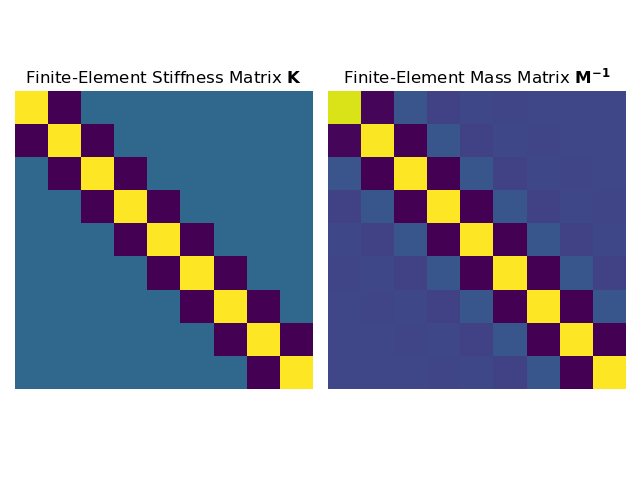

In [16]:
# Display finite element matrices
# ---------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(K[1:10,1:10])
ax1.set_title('Finite-Element Stiffness Matrix $\mathbf{K}$')
ax1.axis("off")

ax2.imshow(Minv[1:10,1:10])
ax2.set_title('Finite-Element Mass Matrix $\mathbf{M^{-1}}$')
ax2.axis("off")

plt.tight_layout()
plt.show()

### 5. Finite differences matrices
We implement a finite difference scheme using matrix-vector operations in order to compare with the finite elements solution. 

The classic 2nd derivative matrix (corresponding to the stiffness matrix in the finite-element scheme) can be initialized as 

\begin{equation}
D_{ij} = \frac{\mu}{dx^2}
 \begin{pmatrix}
   -2 & 1  &    &    &  \\
    1 & -2 & 1  &    &  \\
      &  & \ddots  &  & \\
      &   & 1 &  -2 & 1\\
      &   &    &  1 & -2
 \end{pmatrix} 
\end{equation}

To bring the finite-difference scheme formally to the same structure we also need the corresponding mass matrix simply using the inverse densities, we initialize with

\begin{equation}
M^{fd}_{ij} = 
 \begin{pmatrix}
   1/{\rho_1} &   &    &    &  \\
     &  1/{\rho_2} &  &    &  \\
      &  & \ddots  &  & \\
      &   &   &  1/{\rho_{N-1}}  & \\
      &   &    &   & 1/{\rho_{N}}
 \end{pmatrix} 
\end{equation}


In [17]:
# Initialize finite differences matrices 
# ---------------------------------------------------------------
Mfd = np.zeros((nx,nx), dtype=float)
D  = np.zeros((nx,nx), dtype=float)
dx = h[1]

for i in range(nx):
    Mfd[i,i] = 1./ro[i]
    if i>0:
        if i<nx-1:
            D[i+1,i] =1
            D[i-1,i] =1
            D[i,i] = -2
            
D = ro0 * vs**2 * D/dx**2

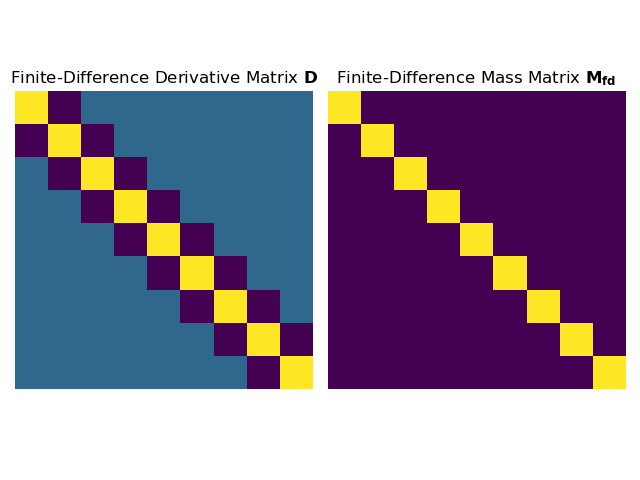

In [18]:
# Display differences matrices
# ---------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(-D[1:10,1:10])
ax1.set_title('Finite-Difference Derivative Matrix $\mathbf{D}$')
ax1.axis("off")

ax2.imshow(Mfd[1:10,1:10])
ax2.set_title('Finite-Difference Mass Matrix $\mathbf{M_{fd}}$')
ax2.axis("off")

plt.tight_layout()
plt.show()

### 6. Finite element solution 

Finally we implement the finite element solution using the computed mass $M$ and stiffness $K$ matrices together with a finite differences extrapolation scheme

\begin{equation}
\mathbf{u}(t + dt) = dt^2 (\mathbf{M}^T)^{-1}[\mathbf{f} - \mathbf{K}^T\mathbf{u}] + 2\mathbf{u} - \mathbf{u}(t-dt).
\end{equation}

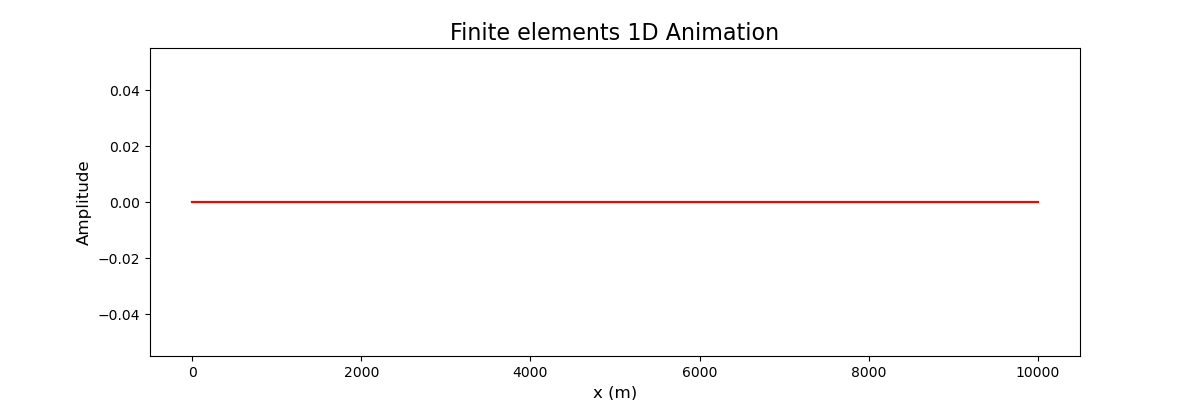

In [19]:
# Initialize animated plot
# ---------------------------------------------------------------
plt.figure(figsize=(12,4))

line1 = plt.plot(x, u, 'k', lw=1.5, label='FEM')
line2 = plt.plot(x, p, 'r', lw=1.5, label='FDM')
plt.title('Finite elements 1D Animation', fontsize=16)
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('x (m)', fontsize=12)

plt.ion()   # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
x_t = []
for it in range(nt):
    # --------------------------------------
    # Finite Element Method
    unew = (dt**2) * Minv @ (f*src[it]  -  K @ u) + 2*u - uold                         
    uold, u = u, unew

    # Solution in space-time 
    x_t.append(u)
    
    # --------------------------------------
    # Finite Difference Method
    pnew = (dt**2) * Mfd @ ( f/dx*src[it]+ D @ p) + 2*p - pold
    pold, p = p, pnew
     
    # --------------------------------------   
    # Animation plot. Display both solutions
    if not it % iplot:
        for l in line1:
            l.remove()
            del l
        for l in line2:
            l.remove()
            del l
        line1 = plt.plot(x, u, 'k', lw=1.5, label='FEM')
        line2 = plt.plot(x, p, 'r', lw=1.5, label='FDM')
        plt.legend()
        plt.gcf().canvas.draw()

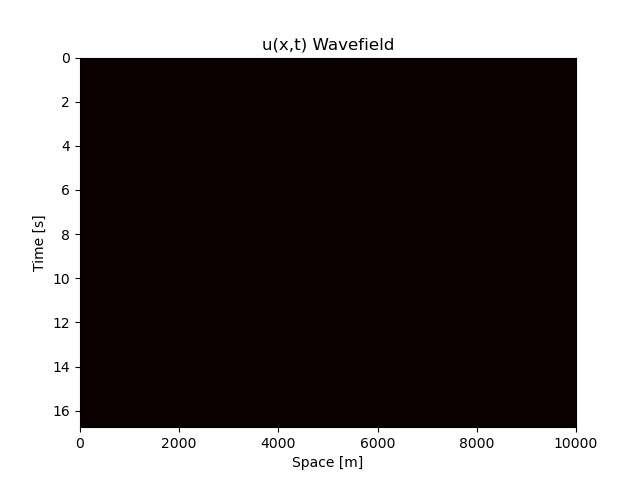

In [20]:
# Solution in space-time
x_t = np.asanyarray(x_t)

# -------------------
# Initialize plot
plt.figure()
plt.subplot(1,1,1)
plt.imshow(x_t, cmap='hot', aspect='auto', 
          extent =[0, xmax,  nt*dt, 0])
plt.title('u(x,t) Wavefield')
plt.ylabel('Time [s]')
plt.xlabel('Space [m]')
plt.show()